In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("outliersloop/footballyolov8")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/footballyolov8


In [2]:
import os
base_path = "/kaggle/input/footballyolov8"

for root, dirs, files in os.walk(base_path):
    print(root)
    break

/kaggle/input/footballyolov8


In [3]:
os.listdir(base_path)

['fr_f_70.txt',
 'fre_f_155_we.txt',
 '22d_f_165_fr.txt',
 'fr_f_130.txt',
 'fr_f_160_fre.txt',
 'fr_f_100_we.jpg',
 'fre_f_190_22d.jpg',
 'we_f_100.txt',
 '22d_f_165_fr.jpg',
 '22d_f_85_fr.txt',
 '6ty_f_110_54r.txt',
 'we_f_175_we.jpg',
 'rt3_f_20_54r.jpg',
 '54r_f_75_we.txt',
 '22d_f_15_rt3.txt',
 'fr_f_55.jpg',
 '54r_f_75.txt',
 'rt3_f_110.jpg',
 'we_f_115_fre.txt',
 '22d_f_185_6ty.txt',
 '54r_f_5_22d.jpg',
 'fre_f_45_22d.jpg',
 'fre_f_145_6ty.txt',
 '22d_f_120_6ty.jpg',
 'rt3_f_35_rt3.txt',
 '6ty_f_85.jpg',
 'fr_f_70.jpg',
 'rt3_f_35_rt3.jpg',
 'fr_f_160_fre.jpg',
 'fr_f_100_we.txt',
 'rt3_f_95.jpg',
 '22d_f_125.jpg',
 'fre_f_60_fr.txt',
 '6ty_f_90_we.txt',
 'we_f_100.jpg',
 '22d_f_25.jpg',
 'fr_f_15.txt',
 '22d_f_80.txt',
 'fr_f_45.jpg',
 '22d_f_120_6ty.txt',
 'fre_f_70_rt3.txt',
 'fr_f_40.txt',
 '54r_f_120.txt',
 '22d_f_125.txt',
 '22d_f_135_we.txt',
 'fre_f_45_22d.txt',
 '6ty_f_195_6ty.txt',
 'rt3_f_170_6ty.jpg',
 '22d_f_200_rt3.txt',
 'fr_f_10.jpg',
 '6ty_f_50_we.jpg',
 'fr_f_1

### Separate Images and Labels

In [4]:
import os
import shutil

base_path = "/kaggle/input/footballyolov8"
work_path = "/kaggle/working/football_yolo"

os.makedirs(f"{work_path}/images", exist_ok=True)
os.makedirs(f"{work_path}/labels", exist_ok=True)

### Move Files into Correct Folders

In [5]:
for file in os.listdir(base_path):
    src = f"{base_path}/{file}"
    
    if file.endswith(".jpg"):
        shutil.copy(src, f"{work_path}/images/{file}")
    
    elif file.endswith(".txt"):
        shutil.copy(src, f"{work_path}/labels/{file}")

In [6]:
print("Images:", len(os.listdir(f"{work_path}/images")))
print("Labels:", len(os.listdir(f"{work_path}/labels")))

Images: 66
Labels: 66


### Image-Label Mapping

In [7]:
images = {f.split('.')[0] for f in os.listdir(f"{work_path}/images")}
labels = {f.split('.')[0] for f in os.listdir(f"{work_path}/labels")}

print("Missing labels:", images - labels)
print("Missing images:", labels - images)

Missing labels: set()
Missing images: set()


### Visualize Annotations

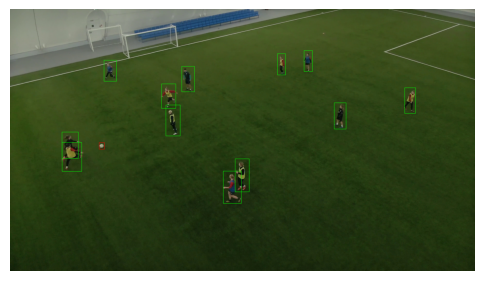

In [8]:
import cv2
import matplotlib.pyplot as plt

img_name = os.listdir(f"{work_path}/images")[0]

img_path = f"{work_path}/images/{img_name}"
label_path = f"{work_path}/labels/{img_name.replace('.jpg','.txt')}"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

with open(label_path) as f:
    for line in f:
        cls, xc, yc, bw, bh = map(float, line.split())
        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)

        color = (0,255,0) if int(cls)==0 else (255,0,0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

### Class Distribution Analysis

In [9]:
from collections import Counter

counter = Counter()

for file in os.listdir(f"{work_path}/labels"):
    with open(f"{work_path}/labels/{file}") as f:
        for line in f:
            cls = int(line.split()[0])
            counter[cls] += 1

print("Players:", counter[0])
print("Football:", counter[1])

Players: 701
Football: 49


### Bounding Box Size Analysis

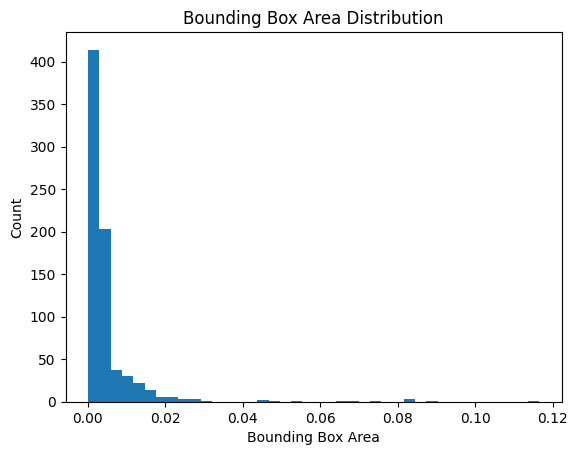

In [10]:
import matplotlib.pyplot as plt

areas = []

for file in os.listdir(f"{work_path}/labels"):
    with open(f"{work_path}/labels/{file}") as f:
        for line in f:
            _, _, _, w, h = map(float, line.split())
            areas.append(w*h)

plt.hist(areas, bins=40)
plt.xlabel("Bounding Box Area")
plt.ylabel("Count")
plt.title("Bounding Box Area Distribution")
plt.show()

### Create YOLO data.yaml

In [11]:
%%writefile /kaggle/working/data.yaml
path: /kaggle/working/football_yolo
train: images
val: images

names:
  0: player
  1: football

Writing /kaggle/working/data.yaml


In [12]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 30.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.6 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Train YOLOv8

In [13]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(data="/kaggle/working/data.yaml", epochs=30, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         66        750      0.914      0.669      0.732      0.415
                player         66        701      0.828      0.993      0.987      0.628
              football         49         49          1      0.345      0.476      0.201
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee328f9a510>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [15]:
import shutil

shutil.make_archive(
    "/kaggle/working/football_yolo",  # zip file name
    "zip",
    "/kaggle/working/football_yolo"   # folder to zip
)

'/kaggle/working/football_yolo.zip'

In [16]:
shutil.make_archive(
    "/kaggle/working/runs",
    "zip",
    "/kaggle/working/runs"
)

'/kaggle/working/runs.zip'

In [17]:
import os

os.listdir("/kaggle/working")

['data.yaml',
 'runs.zip',
 'runs',
 'yolo11n.pt',
 'football_yolo',
 'yolov8n.pt',
 '.virtual_documents',
 'football_yolo.zip']